In [1]:
#reading in data
using CSV,DataFrames, Plots
tData=CSV.read("temperature.csv") #this looks like SI
pData=CSV.read("pressure.csv") #pressure I think is kPA?
pData[end,:]

┌ Info: Recompiling stale cache file /home/kirk/.julia/compiled/v1.1/CSV/HHBkp.ji for CSV [336ed68f-0bac-5ca0-87d4-7b16caf5d00b]
└ @ Base loading.jl:1184
┌ Info: Recompiling stale cache file /home/kirk/.julia/compiled/v1.1/Plots/ld3vC.ji for Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1184


,pressure,altitude
,Float64,Float64
71,945.28,413.7


In [2]:
R_air=287 #J/(kg*K)
yP,yT=(pData.pressure[:]),(tData.temperature[:]) 
xP,xT=(pData[!,Symbol(" altitude")][:]),(tData[!,Symbol(" altitude")][:]) #how to access str colname
pDF,TDF=DataFrame(alt=xP,p=yP.*1e2),DataFrame(alt=xT,T=yT) 
sortedP=sort!(pDF,:alt) #sorts new DF in ascending order 
sortedT=sort!(TDF,:alt) #more logical to me 

,alt,T
,Float64,Float64
1,981.07,298.3
2,1751.0,293.46
3,2378.6,287.59
4,3006.9,282.24
5,3776.2,276.88
6,4333.7,271.35
7,4822.1,267.03
8,5591.5,261.68
9,6360.8,256.32


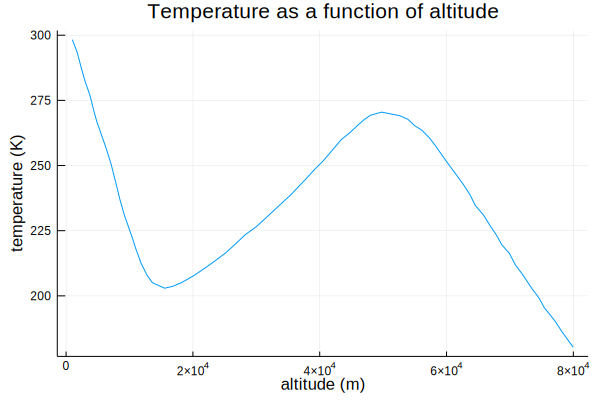

In [3]:
plot(sortedT.alt[:],sortedT.T[:],label="")
plot!(title="Temperature as a function of altitude",xlabel="altitude (m)",ylabel="temperature (K)")

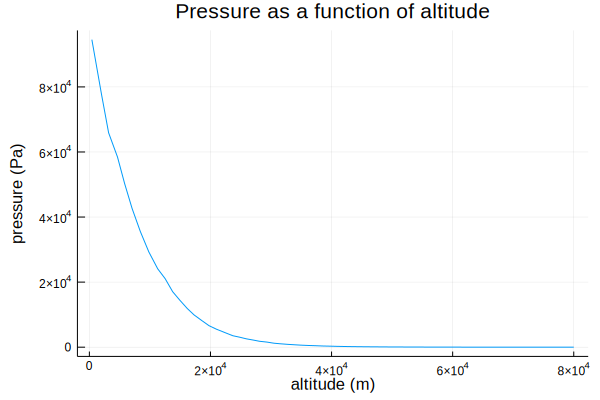

In [4]:
plot(sortedP.alt[:],sortedP.p[:],label="")
plot!(title="Pressure as a function of altitude",xlabel="altitude (m)",ylabel="pressure (Pa)")

In [5]:
using SimplePCHIP
pInterp=SimplePCHIP.interpolate(sortedP.alt[:],sortedP.p[:])
TInterp=SimplePCHIP.interpolate(sortedT.alt[:],sortedT.T[:])
xRangeP=range(sortedP.alt[1],stop=sortedP.alt[end],length=100)
xRangeT=range(sortedT.alt[1],stop=sortedT.alt[end],length=100)
yInterpP=[pInterp(x) for x in xRangeP]
yInterpT=[TInterp(x) for x in xRangeT]

100-element Array{Float64,1}:
 298.3             
 293.24598353546963
 285.82711673441884
 279.7146281444344 
 272.96194596477244
 265.92398278745134
 260.4609361702952 
 254.78851584775305
 248.1182098422329 
 240.1526992505185 
 232.82664529347866
 226.99565938742845
 221.3871664318179 
   ⋮               
 210.70540920685787
 208.2030000721519 
 205.24253836004357
 202.44022254114577
 199.85890631652398
 196.44311466762022
 193.72948785936669
 191.37135826487207
 188.62765491859412
 185.63179446509773
 182.98847700116062
 180.31            

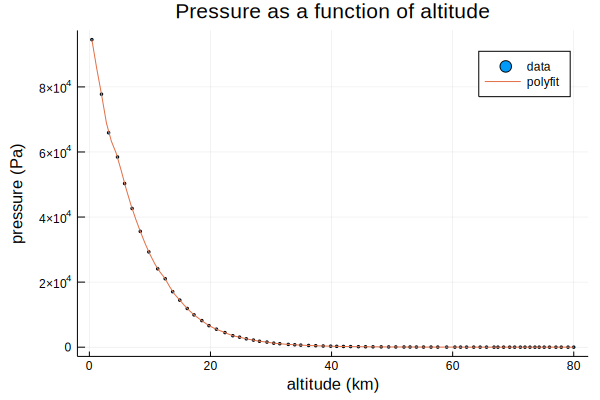

In [6]:
scatter(sortedP.alt[:]./1e3,sortedP.p[:],label="data",markersize=1)
plot!(title="Pressure as a function of altitude",xlabel="altitude (km)",ylabel="pressure (Pa)")
plot!(xRangeP./1e3,yInterpP,label="polyfit")

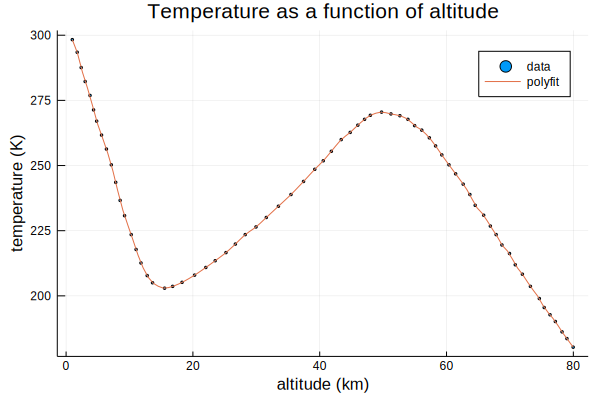

In [7]:
scatter(sortedT.alt[:]./1e3,sortedT.T[:],label="data",markersize=1)
plot!(title="Temperature as a function of altitude",xlabel="altitude (km)",ylabel="temperature (K)")
plot!(xRangeT./1e3,yInterpT,label="polyfit")

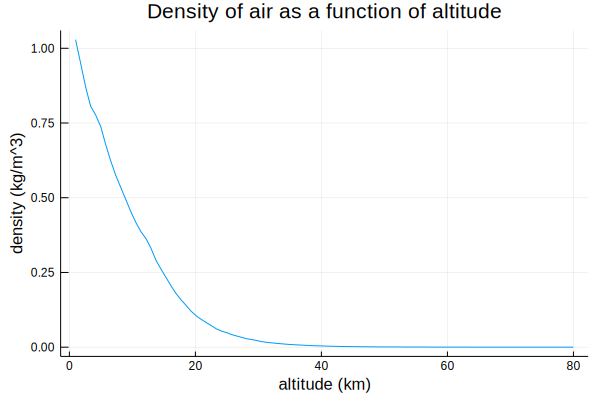

In [8]:
function rho(pFun,TFun,y) #note: this only works to lowest alt value in data (981 in T)
    R_air=287 #J/(kg*K)
    return pFun(y)/(R_air*TFun(y))
end

plot(xRangeT./1e3,[rho(pInterp,TInterp,y) for y in xRangeT],label="")
plot!(title="Density of air as a function of altitude",xlabel="altitude (km)",ylabel="density (kg/m^3)")


In [9]:
function aG(y) #gravitational acceleration
    G=6.67e-11 #Nm^2/kg^2
    Me=5.98e24 #kg
    Re=6356.8e3 #m
    return G*Me/((Re+y)^2)
end

function vSound(y,TFun)
    kappa=1.4 #adiabatic index
    R_air=287 #J/(kg*K)
    T=TFun(y)
    return sqrt(kappa*R_air*T)
end
    
function cDA(t) #suggested in problem
    if t<=25
        return 0.18
    elseif t>75
        return 0.85
    else
        return 0.73
    end
end

function aDrag(m,y,v,TFun,pFun,t) #deceleration due to drag
    cD=cDA(t)
    currentRho=rho(pFun,TFun,y)
    return 0.5*currentRho*cD*(v^2)/m
end

function aY(r,t,constants) #total acc, d^2y/dt^2
    m=constants[1]
    TFun=constants[2]
    pFun=constants[3]
    v=r[2] #current velocity
    y=r[1] #current position
    a=-aG(y)+aDrag(m,y,v,TFun,pFun,t)
    return [v,a]
end

aY (generic function with 1 method)

In [10]:
#initial conditions
y0=39045.0 #m, different from what is given in problem but taken from article
v0=0.0 #m/s
t0=0.0 #s

y=[y0] #initialize empty arrays
t=[t0] #unsure of size so cannot preallocate
v=[v0] 
rhoList=[rho(pInterp,TInterp,y0)]
dragF=[0.0]
vMach=[0.0]

currentY=y0
currentV=v0
current_t=t0
r=[currentY,currentV]

mB=118 #kg, mass of Felix Baumgartner + equipment
constants=[mB,TInterp,pInterp]
a=[aY(r,current_t,constants)[2]]
dt=0.125/2 #s, using value capable of exact binary representation

while currentY>(2e3+1.22e3) #problem says to stop at 2 km, he landed in desert that was 1.22km above sea level
    k1=dt*aY(r,current_t,constants)
    k2=dt*aY(r.+0.5*k1,current_t+0.5*dt,constants)
    k3=dt*aY(r.+0.5*k2,current_t+0.5*dt,constants)
    k4=dt*aY(r.+k3,current_t+dt,constants)
    r.+=(k1+2*k2+2*k3+k4)/6 #result of RK4 calc
    currentV=r[2] 
    currentY=r[1]
    current_t+=dt
    #add new values to arrays
    push!(t,current_t)
    push!(y,currentY)
    push!(v,currentV)
    push!(vMach,currentV/vSound(currentY,TInterp))
    push!(a,aY(r,current_t,constants)[2])
    push!(rhoList,rho(pInterp,TInterp,currentY))
    push!(dragF,aY(r,current_t,constants)[2]+aG(currentY))
end

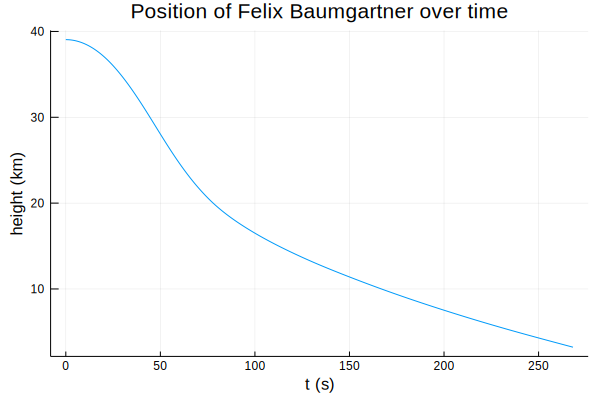

In [11]:
plot(t,y./1e3,label="")
plot!(title="Position of Felix Baumgartner over time",xlabel="t (s)",ylabel="height (km)")

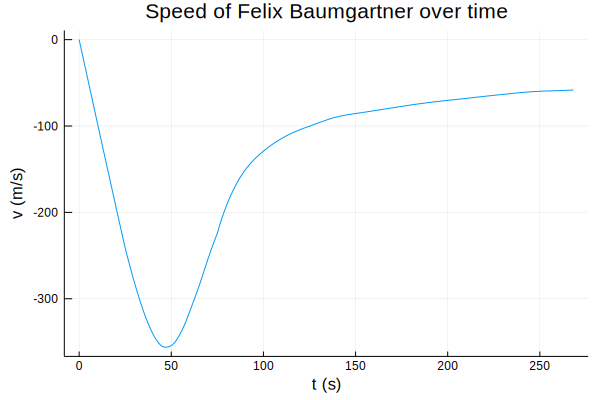

In [12]:
plot(t,v,label="")
plot!(title="Speed of Felix Baumgartner over time",xlabel="t (s)",ylabel="v (m/s)")

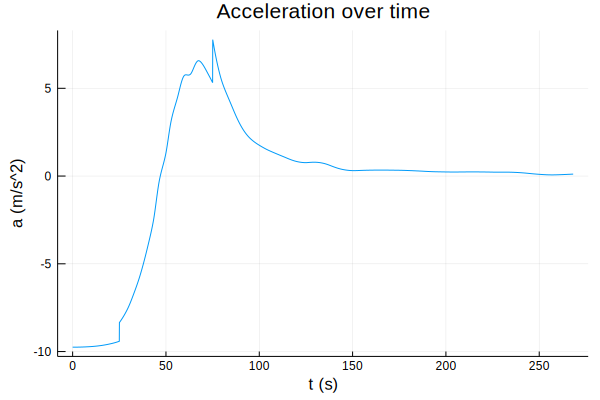

In [13]:
plot(t,a,label="")
plot!(title="Acceleration over time",xlabel="t (s)",ylabel="a (m/s^2)")

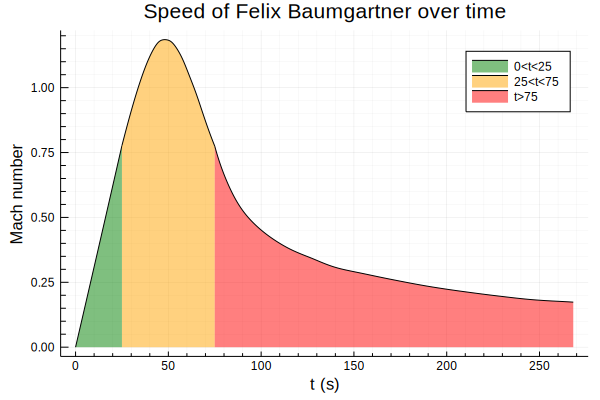

In [14]:
tPoI=[25,75]
tInd=[Int(time/dt+1) for time in tPoI] #indices of times we are interested in
plot(t[1:tInd[1]],abs.(vMach[1:tInd[1]]),fill=(0,0.5,:green),label="0<t<25",linecolor=:black)
plot!(t[tInd[1]:tInd[2]],abs.(vMach[tInd[1]:tInd[2]]),fill=(0,0.5,:orange),label="25<t<75",linecolor=:black)
plot!(t[tInd[2]:end],abs.(vMach[tInd[2]:end]),fill=(0,0.5,:red),label="t>75",linecolor=:black)
plot!(title="Speed of Felix Baumgartner over time",xlabel="t (s)",ylabel="Mach number",minorgrid=true,minorticks=true)

In [15]:
using Formatting
actual_t=4*60+20 #published time in article
actual_max_v=1.24 #published max Mach # in article
publishedVMax=834*1.61e3/3600 #published value in m/s converted from 834 mph
foundVMax=maximum(abs.(v))
foundT=t[end]
foundVMaxMach=maximum(abs.(vMach))
vErr=abs(foundVMax-publishedVMax)/publishedVMax
tErr=abs(foundT-actual_t)/actual_t
vMachErr=abs(foundVMaxMach-actual_max_v)/actual_max_v
println("found free-fall time: ",foundT)
println("published free-fall time: ",actual_t)
println("percent error: ",format(tErr*100,precision=2)," %")
println("found maximum velocity: ",format(foundVMax,precision=2)," m/s")
println("published maximum velocity: ",format(publishedVMax,precision=2)," m/s")
println("percent error: ",format(vErr*100,precision=2)," %")    
println("found maximum velocity: Mach ",format(foundVMaxMach,precision=2))
println("published maximum velocity: Mach ",actual_max_v)
println("percent error: ",format(vMachErr*100,precision=2)," %")

found free-fall time: 268.1875
published free-fall time: 260
percent error: 3.15 %
found maximum velocity: 356.07 m/s
published maximum velocity: 372.98 m/s
percent error: 4.53 %
found maximum velocity: Mach 1.19
published maximum velocity: Mach 1.24
percent error: 4.43 %


### Discussion of results:
According to my simulation, which uses an explicit implementation of a 4th order Runge-Kutta solver, Felix Baumgartner would have theoretically reached a maximum velocity of $\sim$356 m/s, or $\sim$Mach 1.2. In my model he would have spent roughly 4 minutes and 28 seconds in freefall before opening his parachute. As shown above, these values are pretty close to the published values with percent errors of $\sim 3\%$ and $\sim 4.5\%$ respectively. We can see from the plots that the acceleration (and by extension, velocity) are indeed related to the density of air--initially Baumgartner is in a near-vacuum and can accelerate freely under the influence of gravity, but as he loses altitude the air he passes through increases in density, which in turn increases the drag force on him and slows him down, resulting in a region with a net positive acceleration value. The assumed transition times are really close to where my Mach value goes to 0.8, but they appear to slightly undershoot it.

In [41]:
#testing to make animation but decided to be lazy and give up
using Printf,Measures
#l=@layout[a b]


anim1=@animate for i=1:length(y)
    print(format(i/length(y)*100,precision=2),"% complete\r") #output tracker
    plt1=plot(ones(i),[y[1:i]/1e3],xlim=(0,2),size=(1200,2400),label="",xticks=false,grid=false,titlefontsize=42,
        yaxis=((0,maximum(y)/1e3),0:1:maximum(y)/1e3,font(32,"Courier")),left_margin=5mm)
    plt1=scatter!([1],[y[i]/1e3],markersize=10*dragF[i],markeralpha=rhoList[i]+0.2,markercolor=:red,label="",title="Altitude (km)\n")
    #plt2=bar([abs(vMach[i])])
    plt2=bar([abs(vMach[i])],label="",grid=false,xticks=false,yaxis=((0,1.25),
        0:0.1:1.25,font(32,"Courier")),titlefontsize=42,size=(2000,2400),fillcolor=:blue,
        title="Speed (Mach number)\nt: $(@sprintf("%.2f", t[i])) s",left_margin=5mm)
    plt3=bar([a[i]],label="",grid=false,xticks=false,yaxis=((minimum(a),maximum(a)),font(32,"Courier")),
        titlefontsize=42,size=(2000,2400),fillcolor=:red,title="Acceleration (m/s²)\n")
    #push!(plt1,[1],open("initCond.txt","w") do f
    write(f,"m1=$m[1] m2=$m[2] m3=$m[3]\n
            ")[y[i]/1e3])
    #push!(plt2,abs(vMach[i]))
    plot(plt1,plt2,plt3,layout=(1,3),margin=40mm)
    #title!("t: $(@sprintf("%.2f", t[i]))")
    end every 5 #skip 10 each time
gif(anim1,"test_fps30.mp4",fps=30)

┌ Info: Saved animation to 
│   fn = /home/kirk/Documents/school/test_fps30.mp4
└ @ Plots /home/kirk/.julia/packages/Plots/h3o4c/src/animation.jl:95


Plots.AnimatedGif("/home/kirk/Documents/school/test_fps30.mp4")

In [29]:
gif(anim1,"test_fps30.mp4",fps=30)

┌ Info: Saved animation to 
│   fn = /home/kirk/Documents/school/test_fps30.mp4
└ @ Plots /home/kirk/.julia/packages/Plots/h3o4c/src/animation.jl:95


Plots.AnimatedGif("/home/kirk/Documents/school/test_fps30.mp4")

In [76]:
l=@layout[a b]

Plots.GridLayout(1, 2)

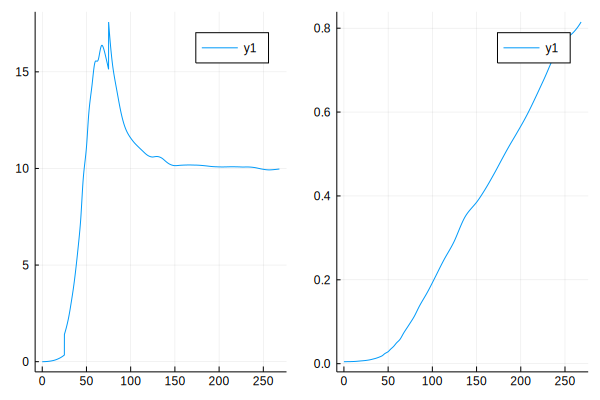

In [21]:
p1=bar([maximum(abs.(vMach))])
p2=plot(t,dragF)
p3=plot(t,rhoList)

plot(p2,p3,layout=(1,2))


In [16]:
minimum(y)

3216.5930745263454

In [1]:
using Random

In [10]:
x=rand(1:10,1)

1-element Array{Int64,1}:
 6

In [11]:
x[1]

6

In [12]:
using Statistics

In [14]:
std(x)

NaN